In [46]:
!pip install kagglehub


In [47]:
import kagglehub

# Download dataset from Kaggle automatically via kagglehub
path = kagglehub.dataset_download("samuelcortinhas/sports-balls-multiclass-image-classification")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/sports-balls-multiclass-image-classification


In [48]:
import os

# Your images are probably inside:
base_dir = os.path.join(path, "sports-balls")

# Sanity check
print("Dataset directory:", base_dir)



Dataset directory: /kaggle/input/sports-balls-multiclass-image-classification/sports-balls


In [49]:
import tensorflow as tf

# Correct base directory path
base_dir = '/kaggle/input/sports-balls-multiclass-image-classification/train'

# Image settings
img_height = 224
img_width = 224
batch_size = 32

# Load training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)



Found 7328 files belonging to 15 classes.
Using 5863 files for training.
Found 7328 files belonging to 15 classes.
Using 1465 files for validation.


In [50]:
from tensorflow.keras import layers, models

num_classes = len(train_ds.class_names)  # 🔥 Add this line

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model

inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)



In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Compile model before training
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, verbose=1),
    ModelCheckpoint("mobilenetv2_best.keras", save_best_only=True, monitor="val_accuracy")
]

# Training
initial_epochs = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=initial_epochs,
                    callbacks=callbacks)


Epoch 1/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 42s 154ms/step - accuracy: 0.1088 - loss: 2.9376 - val_accuracy: 0.3939 - val_loss: 2.0458 - learning_rate: 1.0000e-04
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - accuracy: 0.3619 - loss: 2.0402 - val_accuracy: 0.6061 - val_loss: 1.5073 - learning_rate: 1.0000e-04
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.5405 - loss: 1.5572 - val_accuracy: 0.6874 - val_loss: 1.2189 - learning_rate: 1.0000e-04
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.6370 - loss: 1.2760 - val_accuracy: 0.7222 - val_loss: 1.0531 - learning_rate: 1.0000e-04
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.6802 - loss: 1.1118 - val_accuracy: 0.7522 - val_loss: 0.9483 - learning_rate: 1.0000e-04
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.7147 - loss: 0.9941 - val_accuracy: 0.7645 - val_loss: 0.8745 - learning_rate: 1.0000e-04
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms

In [52]:
# Unfreeze some layers in base_model
base_model.trainable = True

# Optional: Freeze first X layers (tune this for performance vs. speed)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         callbacks=callbacks)


Epoch 10/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 55s 184ms/step - accuracy: 0.6201 - loss: 1.2394 - val_accuracy: 0.7952 - val_loss: 0.6822 - learning_rate: 1.0000e-05
Epoch 11/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 95ms/step - accuracy: 0.7569 - loss: 0.8418 - val_accuracy: 0.8027 - val_loss: 0.6528 - learning_rate: 1.0000e-05
Epoch 12/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - accuracy: 0.7989 - loss: 0.7037 - val_accuracy: 0.8109 - val_loss: 0.6190 - learning_rate: 1.0000e-05
Epoch 13/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.8118 - loss: 0.6104 - val_accuracy: 0.8246 - val_loss: 0.5860 - learning_rate: 1.0000e-05
Epoch 14/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 22s 105ms/step - accuracy: 0.8445 - loss: 0.5278 - val_accuracy: 0.8341 - val_loss: 0.5532 - learning_rate: 1.0000e-05
Epoch 15/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8609 - loss: 0.4665 - val_accuracy: 0.8403 - val_loss: 0.5298 - learning_rate: 1.0000e-05
Epoch 16/40
184/184 ━━━━━━━━━━━━━━━━━━━━ 18

In [53]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"\n✅ Final validation accuracy: {val_acc * 100:.2f}%")


46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.8938 - loss: 0.3687

✅ Final validation accuracy: 89.90%


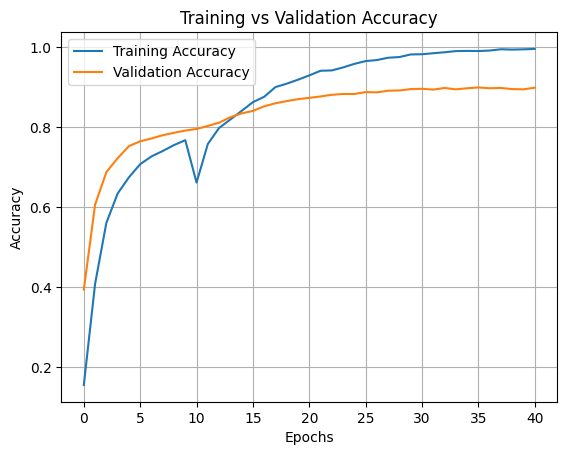

In [54]:
# Save final model
model.save("final_model.keras")

# Plot accuracy
import matplotlib.pyplot as plt

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.title("Training vs Validation Accuracy")
plt.show()


In [55]:
import os

print("Downloaded path:", path)
print("\nDirectory structure:")

# List contents of root path
for root, dirs, files in os.walk(path):
    print(f"\n📁 {root}")
    for d in dirs:
        print(f"  📂 {d}")
    for f in files:
        print(f"  📄 {f}")


Downloaded path: /kaggle/input/sports-balls-multiclass-image-classification

Directory structure:

📁 /kaggle/input/sports-balls-multiclass-image-classification
  📂 test
  📂 train

📁 /kaggle/input/sports-balls-multiclass-image-classification/test
  📂 rugby_ball
  📂 hockey_ball
  📂 volleyball
  📂 golf_ball
  📂 football
  📂 shuttlecock
  📂 baseball
  📂 american_football
  📂 hockey_puck
  📂 table_tennis_ball
  📂 billiard_ball
  📂 bowling_ball
  📂 basketball
  📂 cricket_ball
  📂 tennis_ball

📁 /kaggle/input/sports-balls-multiclass-image-classification/test/rugby_ball
  📄 rugby_ball_629.jpg
  📄 rugby_ball_709.jpg
  📄 rugby_ball_425.jpg
  📄 rugby_ball_279.jpg
  📄 rugby_ball_816.jpg
  📄 rugby_ball_181.jpg
  📄 rugby_ball_627.jpg
  📄 rugby_ball_789.jpg
  📄 rugby_ball_419.jpg
  📄 rugby_ball_263.jpg
  📄 rugby_ball_613.jpg
  📄 rugby_ball_686.jpg
  📄 rugby_ball_164.jpg
  📄 rugby_ball_849.jpg
  📄 rugby_ball_61.jpg
  📄 rugby_ball_232.jpg
  📄 rugby_ball_305.jpg
  📄 rugby_ball_583.jpg
  📄 rugby_ball_911